# Using web APIs

In this lab session we will make use of three web APIs, all able to respresent the resources as JSON and using the HTTPS protocol to exchange the information:
- a simple brewerey api
- an api with data on the corona virus
- a trading api (for this you will need to make an account to get your own API key)


## As usual fill in the CODE_HERE with python code

In [ ]:
!pip install plotly
!pip install numpy
!pip install pandas

In [ ]:
import json
import http.client
import mimetypes

from datetime import datetime, timedelta

import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px

import pandas as pd
import numpy as np

### A brewery example

To use web APIs based on the HTTP protocol we first need to be able to make an HTTP connection <br>

Python has a standard library http.client that is able to do that for you <br>

There is a third-party library "requests" that they actually recommend <br>

Documentation for this very simple demo brewery api can be found here: https://www.openbrewerydb.org/documentation/01-listbreweries <br>

The base endpoint is https://api.openbrewerydb.org/breweries <br>

By using parameters in the url, i.e. key value pairs after the question mark, we can select breweries per city <br>

Example: https://api.openbrewerydb.org/breweries?by_city=san_diego <br>

Let's first make a HTTP connection to api.openbrewerydb.org

In [ ]:
base_url = "api.openbrewerydb.org"

conn = http.client.HTTPSConnection(base_url)

### Now we can use the connection object to make a request

For API calls where we just want to retrieve a resource object, we typically use the HTTP GET method (but always verify with the documentation)

In [ ]:
endpoint = "/breweries"
conn.request("GET", endpoint)

### Next we retrieve the response and transform it into a Python JSON object

In [ ]:
def get_response(conn):
    response = conn.getresponse() 
    if response.status == 200: #OK status code as defined by HTTP protocol
        return json.loads(response.read())
    else:
        print(f"status code: {response.status}")

In [ ]:
response = get_response(conn)
conn.close()

In [ ]:
#this is how one element in the response list looks like
print(json.dumps(response[0], indent=2))

### Let's print the brewery names and city

In [ ]:
for brewery in response:
    print(brewery["name"],",",brewery["city"])

### Sometimes we want specific resources, e.g. breweries in certain cities
Typically the API documentation will tell you how <br>
To select breweries in one city the brewery API allow us to specify a parameter "by_city" in the URL <br>
Let's get all breweries in Tucson

In [ ]:
city = "Tucson"
endpoint = f"/breweries?by_city={city}"

conn = http.client.HTTPSConnection(base_url)
conn.request("GET", endpoint)
response = get_response(conn)
conn.close()

for brewery in response:
    print(brewery["name"], ",", brewery["city"])

### When dealing with flat json objects (relational structured data), you can store them as a Pandas dataframe
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

In [ ]:
conn = http.client.HTTPSConnection(base_url)
conn.request("GET", endpoint)
response = get_response(conn)
conn.close()

brewery_df = pd.DataFrame(response)
print(brewery_df.groupby("brewery_type").agg({"id": len}))

# Now it's your turn

### Let's make some plots to compare the progress of the number corona infections/deaths in China, Belgium, Netherlands, Italy, Spain and the US

To visualize exponential growth we will make plots as demonstrated here: https://www.youtube.com/watch?v=54XLXg4fYsc&t=305s <br>

We will use the data provided by the web API: https://documenter.getpostman.com/view/2568274/SzS8rjbe?version=latest

In [ ]:
list_of_countries = ["CHN","BEL","NLD","ITA","ESP","USA"]

### Let's first make a class to simplify the reuse of the connection object, request and responses, catch and deal with some potential errors

To fetch the data for a country and a range of dates take a look at the country specific time series documentation:
https://documenter.getpostman.com/view/2568274/SzS8rjbe?version=latest#9831da5b-af37-4444-97ed-3e1f6477080d

In [ ]:
class CoronaSDK():
    def __init__(self, host):
        self.host = host
        self.conn = http.client.HTTPSConnection(self.host)
    
    #to enable the use of the with statement
    def __enter__(self):
        return self
    
    #to enable the use of the with statement: always close the connection whatever happens
    def __exit__(self, type, value, traceback):
        self.close()
    
    def close(self):
        self.conn.close()
        self.conn = None
    
    def get(self, endpoint):
        """
        :param endpoint: the path after the domain name in the url, e.g. /breweries
        
        :returns: return data of endpoint as JSON
        """
        #send request use the self.conn variable
        CODE_HERE 
        
        try:
            #try to get response
            response = CODE_HERE
        except (http.client.NotConnected, http.client.RemoteDisconnected):
            self.conn.connect() #reconnect in case the connection was closed by the other end
            return self.get(endpoint)
        except http.client.HTTPException as httpe:
            print(f"Error: {httpe}")
            return None

        if response.status == 200: #OK status code as defined by HTTP protocol
            CODE_HERE #read from the response and return it as JSON
        else:
            print(f"status code: {response.status}")
            return None
        
    def get_covid_data_for_country(self, country_code):
        """
        fetch the corona data for a specified country from 2020-01-01 uptill now
        
        :returns: list of the form
        
            {
              "confirmed": integer,
              "date": "%Y-%m-%d",
              "deaths": integer,
              "recovered": integer,
            }
        """
        today_str = datetime.now().strftime("%Y-%m-%d")
        CODE_HERE #construct the endpoint string to fetch data for the given country uptil today_str
        return self.get(endpoint)["result"]

### Let's use an object of the CoronaSDK class and the above defined method get_covid_data_for_country to retrieve the data for Belgium

The covid api hostname is covidapi.info <br>
BEL is the symbol for Belgium

In [ ]:
client = CODE_HERE #create object of CoronaSDK
response = CODE_HERE #call the get_covid_data_for_country for Belgium
print(f'Example record: {response[-1]}')

### Let's now use that function to retrieve the data for all countries in the previously defined list list_of_countries

The output variable records should be a list containing dictionaries/flat JSON objects of the form

```
{
  "confirmed": integer,
  "date": "%Y-%m-%d",
  "deaths": integer,
  "recovered": integer,
  "country": "country code e.g. BEL"
}
```

Do that by iterating over the list of countries and don't forget to add the country code to each record using the key 'country'

In [ ]:
records = []
for country_code in list_of_countries:
    country_recs = CODE_HERE
    for rec in country_recs:
        CODE_HERE #add the country code to the record rec
    records.extend(country_recs)

In [ ]:
print(records[0])
assert len(set(records[0]) & set(["confirmed","date","deaths","recovered","country"])) == 5

### Let's put the list of records in a table structure, i.e. a pandas DataFrame

Please read the pandas documentation to make dataframes: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

In [ ]:
covid_df = pd.DataFrame(CODE_HERE, columns=CODE_HERE)
print(covid_df.head(5))

### Let's make a pivot table with as rows the dates, as columns the different countries and as values the number of deaths on that date
### Each column then represents a timeseries of the number of deaths for that country over time

Please read the pandas documentation here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html <br>

The output DataFrame of the pivot table should look something like
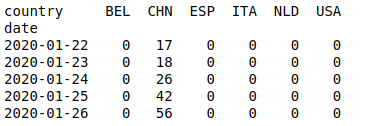

In [ ]:
pivot_df = pd.pivot_table(covid_df, values=CODE_HERE, index=CODE_HERE, columns=CODE_HERE, aggfunc=np.sum)

In [ ]:
print(pivot_df.head(5))
assert pivot_df.loc["2020-01-22"]["CHN"] == 17

### Let's make a timeseries plot of these values for each country

Checkout the documentation on plotly to understand how you can make line plots with their Scatter class: https://plotly.com/python/line-and-scatter/

Should look something like
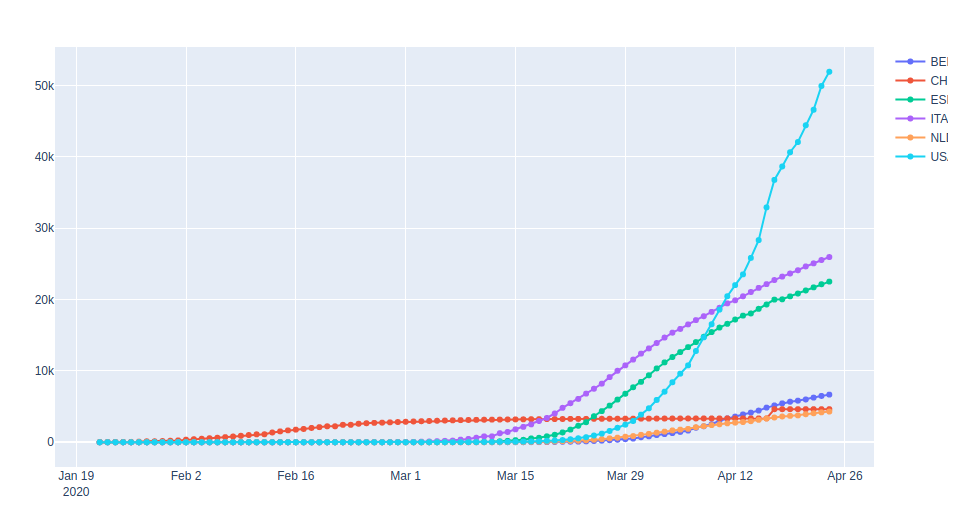

In [ ]:
def create_country_traces(df):
    traces = []
    for col in df.columns: #iterating over the countries
        traces.append(go.Scatter(
                            x=df.index, #the dates
                            y=df[col].values, #the value for that country
                            name = col,
                            mode = 'markers+lines',
                            line=dict(shape='linear'),
                            connectgaps=True
                        )
                 )
    return traces

In [ ]:
#create figure with specified width and height
fig = go.Figure(
    layout=go.Layout(
      width=1000,
      height=600
    )
)

#add the individual country line plots to the figure
for trace in create_country_traces(pivot_df):
    fig.add_trace(trace)
    
fig.show()

### make the same chart, but now use log-scaling for the Y-axis

Read the documentation on the Layout object: https://plotly.com/python/reference/#layout-yaxis

In [ ]:
fig = go.Figure(
    layout=go.Layout(
      yaxis= CODE_HERE #see documentation,
      width=1000,
      height=600
    )
)

for trace in create_country_traces(pivot_df):
    fig.add_trace(trace)
    
fig.show()

### Let's now plot the number of new deaths in the last 7 days (on the Y-axis - log scale) versus the total number of deaths (on the X-axis - log scale)

Let's first compute a new DataFrame that computes this moving 7-day difference <br>

checkout pandas method diff: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html

In [ ]:
diff_df = pivot_df.diff(CODE_HERE)

In [ ]:
print(diff_df.tail(5))
assert diff_df.loc["2020-04-24"]["BEL"] == 1516

### now join the pivot table with this diff table so that we can plot the new deaths versus the total ones


In [ ]:
merged_df = pivot_df.merge(diff_df, left_index=True, right_index=True, suffixes=("_total","_difference"))

In [ ]:
print(merged_df.tail(5))
assert merged_df.loc["2020-04-24"]["BEL_difference"] == 1516
assert merged_df.loc["2020-04-24"]["BEL_total"] == 6679

### Now create the chart using the merged_df DataFrame

add a line plot/trace per country, plotting the column with suffix _total on the x-axis and the column with suffix _difference on the y-axis <br>

use log type for both axis <br>

Should look something like
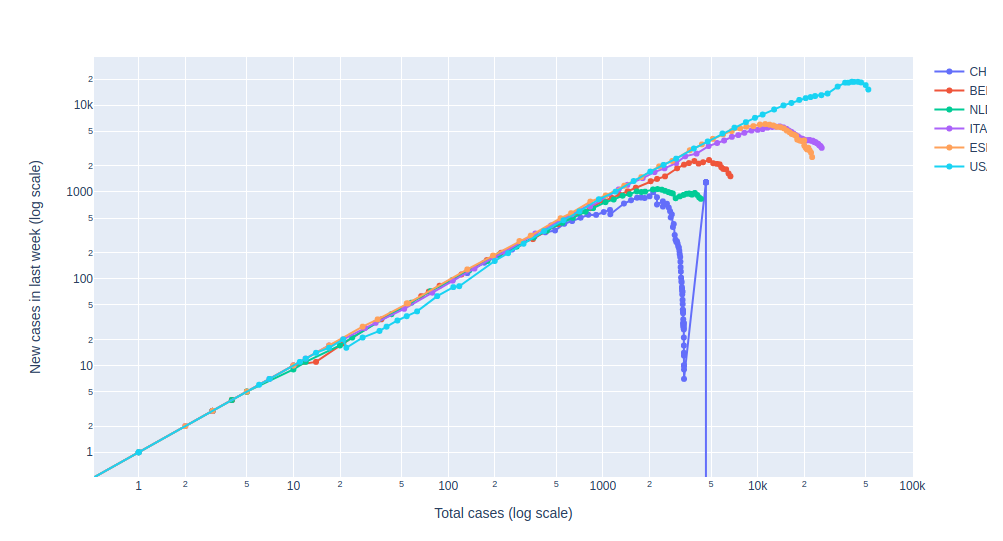

In [ ]:
fig = go.Figure(layout = go.Layout(
    yaxis_title="New cases in last week (log scale)",
    xaxis_title="Total cases (log scale)",
    xaxis_type="log",
    yaxis_type="log",
    width=1000,
    height=600
))

for country_code in list_of_countries:
    col_total = f"{country_code}_total"
    col_difference = f"{country_code}_difference"
    fig.add_trace(go.Scatter(x=merged_df[CODE_HERE], y=merged_df[CODE_HERE],
                             name = CODE_HERE,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                )
    )

fig.show()

### As third example we are going to plot the average stock price per day for Apple (symbol AAPL)

First make an account on iexcloud.io <br>

Once you have setup an account you can access your private/secret api token like in the picture below

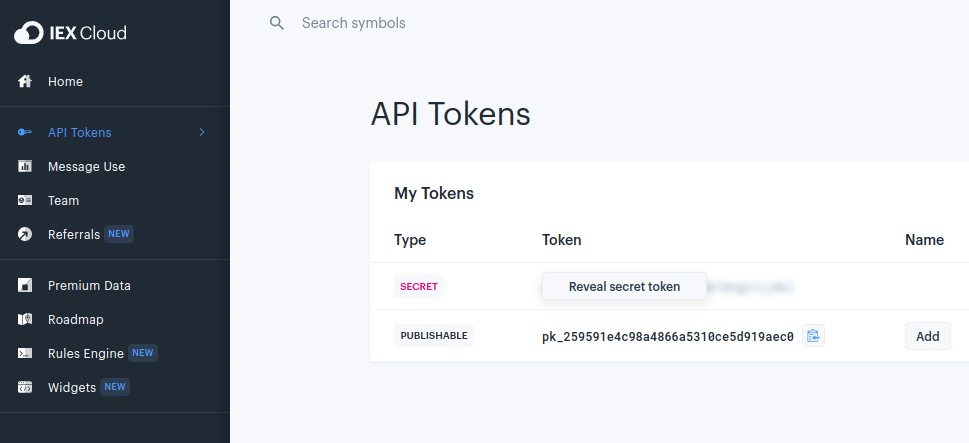

Check out the documentation of the iex API here: https://iexcloud.io/docs/api/#historical-prices

You should pass your token in the request url/endpoint as a key-value parameter: ```?token=<your_token>```

In [ ]:
#fill in your secret API key/token here (should start with sk_)
IEX_TOKEN = CODE_HERE #YOUR_IEX_TOKEN

### Make a class like CoronaSDK, call it IEXSDK that holds the HTTPS connection object and your token

define two functions:
- a function (get_stock_for_symbol_and_date) that retrieves the stock prices for a particular symbol and date: the endpoint looks like /stable/stock/{symbol}/chart/date/{date} where date follows the format %Y%m%d
- a function (get_stock_for_symbol) that uses the previous function to fetch for a given symbol all stock prices between two dates

The second function should return the data as a pandas DataFrame table that looks like the below picture
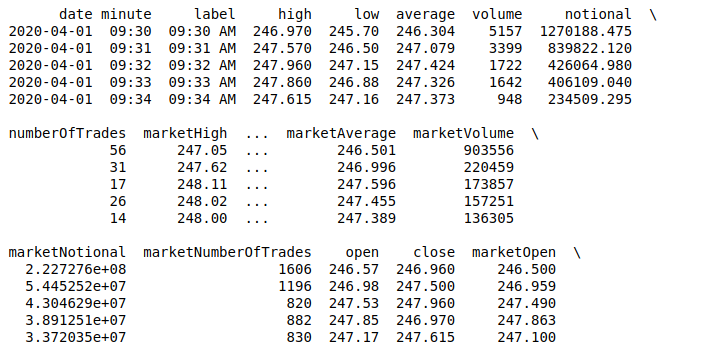

In [ ]:
class IEXSDK():
    def __init__(self, host, token=None):
        self.host = host
        self.token = token
        self.conn = CODE_HERE #create a HTTPS connection object to the specified host
        
    #to enable the use of the with statement
    def __enter__(self):
        return self
    
    #to enable the use of the with statement: always close the connection whatever happens
    def __exit__(self, type, value, traceback):
        self.close()
    
    def close(self):
        self.conn.close()
        self.conn = None
    
    def get(self, endpoint):
        """
        :param endpoint: the path after the domain name in the url, e.g. /breweries
        
        :returns: returns the data returned by the endpoint as JSON
        """
        #complete the entire function, you can use the CoronaSDK class as example 
        #(don't forget to include the self.token in the request)
        CODE_HERE        
    
    def get_stock_for_symbol_and_date(self, symbol, date):
        """
        Fetches the data for the given *symbol* and *date* from the api endpoint
        
        uses the self.get method to retrieve data at the endpoint
        
        :returns: list of records of the form as documented on https://iexcloud.io/docs/api/#historical-prices
        """
        endpoint = f"/stable/stock/{symbol}/chart/date/{date}"
        return self.get(endpoint)
    
    def get_stock_for_symbol(self, symbol, start_date, end_date, date_format="%Y%m%d"):
        """
        Fetches the data for the given symbol between *start_date* and *end_date*
        
        Uses the method get_stock_for_symbol_and_date to fetch the data for one date
        
        :param start_date: start date for which to retrieve data following the date_format format
        :type start_date: str
        :param end_date: end date for which to retrieve data following the date_format format
        :type end_date: str
        
        :returns: returns the data as a pandas DataFrame table with per minute data
        """
        #you will have to convert the start_date and end_date to python datetime objects
        #and then iterate from the start_date to end_date in one day increments
        #for each day call the self.get_stock_for_symbol_and_date method and add it
        #all together in the list from which you create and return a pandas DataFrame
        CODE_HERE #complete the entire function so that it outputs the requested DataFrame

###  create an object of the above class passing the host name cloud.iexapis.com and your token

In [ ]:
client = IEXSDK("cloud.iexapis.com", token=IEX_TOKEN)

### use the client and its corresponding function get_stock_for_symbol to fetch the data between 2020-04-01 and 2020-04-15 for Apple's symbol AAPL

In [ ]:
df = client.get_stock_for_symbol("AAPL","20200401","20200415")

In [ ]:
print(df.head(5))
assert df.iloc[0]["date"] == "2020-04-01"
assert df.iloc[0]["minute"] == "09:30"
assert df.iloc[0]["numberOfTrades"] == 56

### Let's make a box plot per day using the pandas DataFrame (x-axis: date, y-axis: average)

Should look someting like
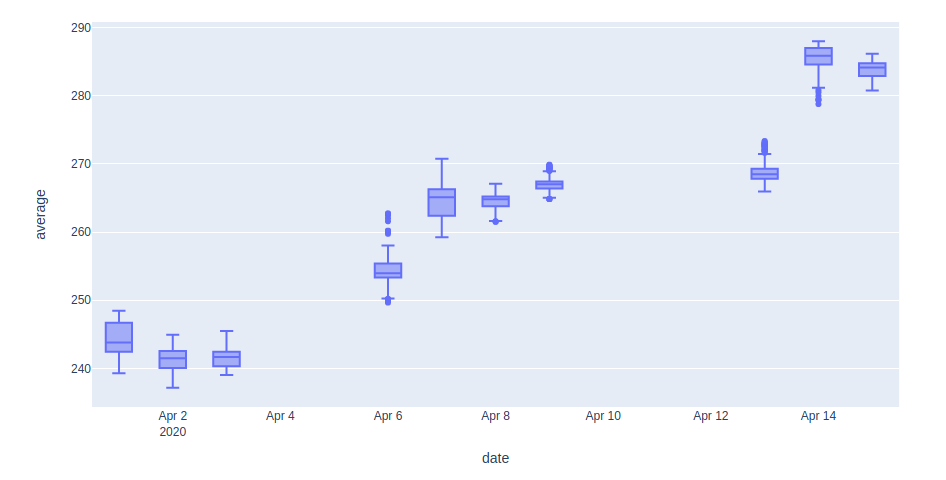

In [ ]:
px.box(df, x="date", y="average")

### let's now take the average of the average minute price per day

Use DataFrame's groupby function together with the agg function to compute both the mean and standard deviation on the average column <br>

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html <br>

The output dataframe should look like
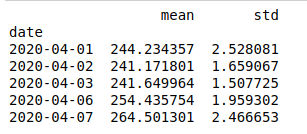

In [ ]:
average_df = CODE_HERE
average_df = average_df.average

In [ ]:
print(average_df.head(5))
assert 244 <= average_df.loc["2020-04-01"]["mean"] <= 245

### Let's make a chart to display the price of the symbol over time per day, together with one standard deviation upperbound and lowerbound

Should look more or less like
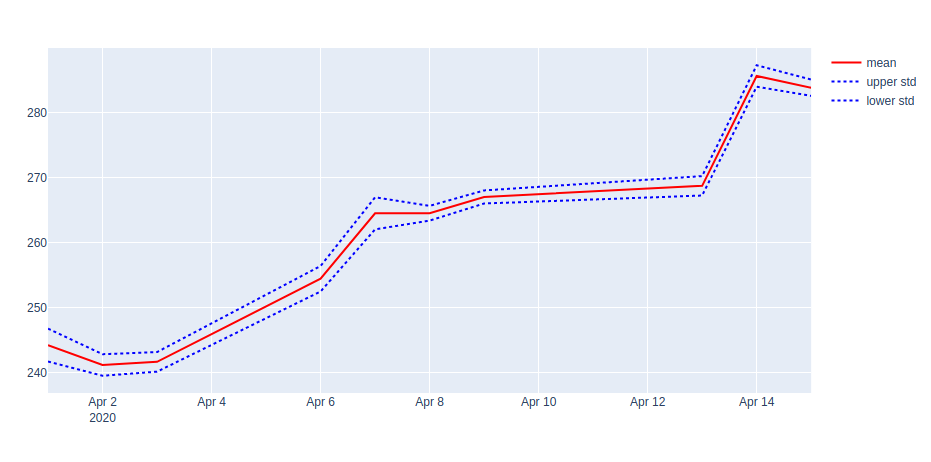

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="mean",
    x=average_df.index.values,
    y=average_df["mean"],
    mode="lines",
    line={"color":"red"}
))
fig.add_trace(go.Scatter(
    name="upper std",
    x=average_df.index.values,
    y=average_df["mean"]+average_df["std"],
    mode="lines",
    line={"color":"blue", "dash":"dot"}
))
fig.add_trace(go.Scatter(
    name="lower std",
    x=average_df.index.values,
    y=average_df["mean"]-average_df["std"],
    mode="lines",
    line={"color":"blue", "dash":"dot"}
))

### Congrats you've managed to complete the session on using web apis with Python

### For more fun with web APIs check out https://www.programmableweb.com/ 

### Have fun with your newly acquired skills!